In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from ecglib.data import load_ptb_xl
from ecglib.data import EcgDataset
import pandas as pd

In [2]:
import time

In [ ]:
import warnings
import neurokit2 as nk
from neurokit2 import NeuroKitWarning

warnings.filterwarnings("ignore") 

In [4]:
from paths import data_dir

In [23]:
from features_analysis import (
    plot_features_vs_age,
    calculate_age_correlations
)
from features_process import (
    get_ecg_signals_features,
)
from subject_process import (
    extract_subjects_info
)
from wave_process import get_waves_quality_stats

In [6]:
"""get_ecg_signals_features(
    processed_dir=path_to_zip/'ptb_xl_npz', 
    output_dir_features='ptb_xl_features_signal_morphology', method="dwt", 
    avg_signal=True, show_plot=False, calc_waves_peak=True,
    fs=fs, extractors=['morphology'], batch_size=5000,
)"""

'get_ecg_signals_features(\n    processed_dir=path_to_zip/\'ptb_xl_npz\', \n    output_dir_features=\'ptb_xl_features_signal_morphology\', method="dwt", \n    avg_signal=True, show_plot=False, calc_waves_peak=True,\n    fs=fs, extractors=[\'morphology\'], batch_size=5000,\n)'

In [6]:
data_dir, data_dir.exists()

(Path('C:/Users/lenovo/Desktop/sci/data/ecg'), True)

In [10]:
dataset = 'ptb_xl'
path_to_zip=data_dir / dataset
frequency = 500

channel_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
fs = 500

# Getting features

In [42]:

"""
def plot_ecg_cycle_with_features(cycle, signal, fs, cycle_num=0):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 1. Автоматическое определение границ цикла --------------------------------------
    available_points = []
    for point in ['ECG_P_Onsets', 'ECG_Q_Peaks', 'ECG_R_Peaks', 'ECG_S_Peaks', 'ECG_T_Offsets']:
        if point in cycle and len(cycle[point]) > 0:
            available_points.append(int(cycle[point][0]))
    
    if not available_points:
        print(f"Цикл {cycle_num}: нет точек для отрисовки")
        return fig
    
    # Границы цикла (с запасом 10% по краям)
    start = max(0, min(available_points) - int(0.1*fs))
    end = min(len(signal), max(available_points) + int(0.1*fs))
    
    # 2. Отрисовка сигнала ----------------------------------------------------------
    time = np.arange(start, end) / fs
    ax.plot(time, signal[start:end], 'b-', linewidth=1.5, label='ЭКГ сигнал')
    
    # 3. Разметка точек (только существующие) ---------------------------------------
    point_style = {
        'ECG_P_Onsets': ('<', 'green', 'P начало'),
        'ECG_P_Peaks': ('o', 'lime', 'P пик'),
        'ECG_P_Offsets': ('>', 'darkgreen', 'P конец'),
        'ECG_Q_Peaks': ('x', 'red', 'Q'),
        'ECG_R_Peaks': ('o', 'black', 'R'),
        'ECG_S_Peaks': ('x', 'blue', 'S'),
        'ECG_T_Onsets': ('<', 'purple', 'T начало'),
        'ECG_T_Peaks': ('o', 'magenta', 'T пик'),
        'ECG_T_Offsets': ('>', 'darkviolet', 'T конец')
    }
    
    for point, (marker, color, label) in point_style.items():
        if point in cycle and len(cycle[point]) > 0:
            x = cycle[point][0] / fs
            y = signal[int(cycle[point][0])]
            ax.plot(x, y, marker=marker, color=color, markersize=10, label=label)
    
    # 4. Отрисовка интервалов (только для существующих пар) -------------------------
    def draw_interval_if_exists(start_point, end_point, y_pos, label):
        if (start_point in cycle and len(cycle[start_point]) > 0 and 
            end_point in cycle and len(cycle[end_point]) > 0):
            x1 = cycle[start_point][0] / fs
            x2 = cycle[end_point][0] / fs
            ax.add_patch(Rectangle((x1, y_pos), x2-x1, 0.1, alpha=0.3, color='gray'))
            ax.text((x1+x2)/2, y_pos+0.15, f'{label}\n{(x2-x1)*1000:.1f} мс', 
                    ha='center', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    y_min = np.min(signal[start:end])
    draw_interval_if_exists('ECG_P_Onsets', 'ECG_P_Offsets', y_min-0.3, 'P')
    draw_interval_if_exists('ECG_Q_Peaks', 'ECG_S_Peaks', y_min-0.5, 'QRS')
    draw_interval_if_exists('ECG_Q_Peaks', 'ECG_T_Offsets', y_min-0.7, 'QT')
    
    # 5. Настройка графика ----------------------------------------------------------
    ax.set_xlabel('Время (с)', fontsize=12)
    ax.set_ylabel('Амплитуда (мВ)', fontsize=12)
    ax.set_title(f'Цикл {cycle_num}', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Убираем дубликаты в легенде
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')
    
    plt.tight_layout()
    return fig

def plot_averaged_signal(avg_signal, before_r, after_r, fs):
    if avg_signal is None:
        print("Невозможно построить график: недостаточно данных")
        return
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 1. Временная ось (в мс относительно R-пика)
    time = (np.arange(len(avg_signal)) - before_r) / fs * 1000  # мс
    
    # 2. Отрисовка сигнала
    ax.plot(time, avg_signal, 'b-', linewidth=2, label='Усредненный ЭКГ')
    
    # 3. Разметка ключевых элементов
    ax.axvline(x=0, color='r', linestyle='--', label='R-пик (0 мс)')
    ax.axvline(x=-before_r, color='gray', linestyle=':', label=f'Начало окна (-{before_r/fs*1000:.0f} мс)')
    ax.axvline(x=after_r, color='gray', linestyle=':', label=f'Конец окна (+{after_r/fs*1000:.0f} мс)')
    
    # 4. Настройка графика
    ax.set_xlabel('Время относительно R-пика (мс)', fontsize=12)
    ax.set_ylabel('Амплитуда (мВ)', fontsize=12)
    ax.set_title(f'Усредненный PQRST комплекс (окно ±{before_r/fs*1000:.0f}/{after_r/fs*1000:.0f} мс)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_averaged_ecg(signal, cycles, fs):
    # 1. Подготовка данных для усреднения
    r_peaks = [int(cycle['ECG_R_Peaks'][0]) for cycle in cycles if 'ECG_R_Peaks' in cycle]
    if len(r_peaks) < 2:
        print("Недостаточно циклов для усреднения")
        return
    
    before_r = int(0.2 * fs)  # 200 мс до R
    after_r = int(0.5 * fs)   # 500 мс после R
    segments = []
    
    for r in r_peaks:
        start = max(0, r - before_r)
        end = min(len(signal), r + after_r)
        segment = signal[start:end]
        
        # Выравнивание по длине (если циклы у границ сигнала)
        if len(segment) < (before_r + after_r):
            pad_width = (before_r + after_r) - len(segment)
            segment = np.pad(segment, (0, pad_width), mode='constant')
        
        segments.append(segment)
    
    # 3. Усреднение и построение
    avg_signal = np.mean(segments, axis=0)
    time = (np.arange(len(avg_signal)) / fs) - 0.2  # Время относительно R-пика
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, avg_signal, 'b-', linewidth=2, label='Усредненный сигнал')
    
    # 4. Разметка характерных точек (медианные положения)
    point_labels = {
        'ECG_P_Peaks': ('P', 'green'),
        'ECG_Q_Peaks': ('Q', 'red'),
        'ECG_S_Peaks': ('S', 'blue'),
        'ECG_T_Peaks': ('T', 'purple')
    }
    
    for point_key, (label, color) in point_labels.items():
        points = []
        for cycle in cycles:
            if point_key in cycle and len(cycle[point_key]) > 0:
                points.append(cycle[point_key][0])
        
        if len(points) > 0:
            median_pos = np.median(points) - r_peaks[0]  # Относительно первого R-пика
            median_time = median_pos / fs
            y_val = np.interp(median_pos, np.arange(len(avg_signal)), avg_signal)
            ax.plot(median_time, y_val, 'o', color=color, markersize=8, label=label)
    
    # 5. Настройка графика
    ax.axvline(x=0, color='black', linestyle='--', label='R-пик')
    ax.set_xlabel('Время относительно R-пика (с)')
    ax.set_ylabel('Амплитуда (мВ)')
    ax.set_title(f'Усредненный PQRST комплекс (n={len(cycles)} циклов)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
"""

'\ndef plot_ecg_cycle_with_features(cycle, signal, fs, cycle_num=0):\n    fig, ax = plt.subplots(figsize=(15, 8))\n\n    # 1. Автоматическое определение границ цикла --------------------------------------\n    available_points = []\n    for point in [\'ECG_P_Onsets\', \'ECG_Q_Peaks\', \'ECG_R_Peaks\', \'ECG_S_Peaks\', \'ECG_T_Offsets\']:\n        if point in cycle and len(cycle[point]) > 0:\n            available_points.append(int(cycle[point][0]))\n\n    if not available_points:\n        print(f"Цикл {cycle_num}: нет точек для отрисовки")\n        return fig\n\n    # Границы цикла (с запасом 10% по краям)\n    start = max(0, min(available_points) - int(0.1*fs))\n    end = min(len(signal), max(available_points) + int(0.1*fs))\n\n    # 2. Отрисовка сигнала ----------------------------------------------------------\n    time = np.arange(start, end) / fs\n    ax.plot(time, signal[start:end], \'b-\', linewidth=1.5, label=\'ЭКГ сигнал\')\n\n    # 3. Разметка точек (только существующие) ----

In [11]:
extract_subjects_info(processed_dir=path_to_zip/'ptb_xl_npz', npz_files=None)

Extracting subject info: 100%|██████████| 18868/18868 [04:17<00:00, 73.24it/s]


,patient_id,target,file_name,age,sex
0,1000,1.0,ecg_1000.npz,86,1
1,10000,1.0,ecg_10000.npz,51,0
2,10002,0.0,ecg_10002.npz,73,0
3,10003,1.0,ecg_10003.npz,63,0
4,10005,0.0,ecg_10005.npz,76,1
...,...,...,...,...,...
18863,9995,1.0,ecg_9995.npz,59,0
18864,9996,1.0,ecg_9996.npz,16,1
18865,9997,1.0,ecg_9997.npz,57,1
18866,9998,0.0,ecg_9998.npz,87,0


In [24]:
info_wave_peaks = get_waves_quality_stats(processed_dir=path_to_zip)

Analyzing waves quality: 100%|██████████| 18204/18204 [01:22<00:00, 219.67it/s]


In [25]:
info_wave_peaks

,I_total_r_peaks,I_ECG_P_Onsets_missing,I_ECG_P_Peaks_missing,I_ECG_P_Offsets_missing,I_ECG_R_Onsets_missing,I_ECG_Q_Peaks_missing,I_ECG_R_Peaks_missing,I_ECG_S_Peaks_missing,I_ECG_R_Offsets_missing,I_ECG_T_Onsets_missing,...,V6_ECG_P_Offsets_missing,V6_ECG_R_Onsets_missing,V6_ECG_Q_Peaks_missing,V6_ECG_R_Peaks_missing,V6_ECG_S_Peaks_missing,V6_ECG_R_Offsets_missing,V6_ECG_T_Onsets_missing,V6_ECG_T_Peaks_missing,V6_ECG_T_Offsets_missing,patient_id
0,10,1,0,0,1,1,0,1,0,0,...,0,1,1,0,1,0,0,0,0,10000
1,15,1,1,1,2,2,0,1,2,2,...,2,7,6,0,1,2,2,2,2,10002
2,12,0,0,0,1,1,0,1,1,1,...,0,1,1,0,1,1,1,1,1,10003
3,14,0,0,0,8,8,0,1,6,6,...,3,12,11,0,1,12,12,12,12,10005
4,14,0,0,0,1,1,0,1,4,1,...,0,1,1,0,1,1,0,0,1,10007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18199,11,0,0,0,1,1,0,1,0,0,...,0,1,1,0,1,1,1,1,1,9996
18200,12,0,0,0,1,1,0,1,0,0,...,0,3,3,0,1,1,0,0,0,9997
18201,13,0,0,0,1,1,0,1,1,1,...,0,1,1,0,1,0,0,0,0,9998
18202,11,1,1,1,2,1,0,1,0,0,...,0,1,1,0,1,0,0,0,0,9999


In [26]:
nonzero_counts = info_wave_peaks.ne(0).sum()
nonzero_counts

I_total_r_peaks             18204
I_ECG_P_Onsets_missing       3026
I_ECG_P_Peaks_missing        1612
I_ECG_P_Offsets_missing      1616
I_ECG_R_Onsets_missing      18204
                            ...  
V6_ECG_R_Offsets_missing     9875
V6_ECG_T_Onsets_missing      7719
V6_ECG_T_Peaks_missing       7533
V6_ECG_T_Offsets_missing     9052
patient_id                  18204
Length: 145, dtype: int64

Found 18868 patient files
C:\Users\lenovo\Desktop\sci\data\ecg\ptb_xl\ptb_xl_features_signal_morphology_avg\dwt C:\Users\lenovo\Desktop\sci\data\ecg\ptb_xl\ptb_xl_peaks_avg\dwt


Processing patients:   0%|          | 0/18868 [00:00<?, ?it/s]

get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
400
get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
Error in find_nearest_crossing: index 4316 is out of bounds for axis 0 with size 4000
Error in calculate_qrs_area: index 4178 is out of bounds for axis 0 with size 4000
Error in find_nearest_crossing: index 4203 is out of bounds for axis 0 with size 4000
Error in find_nearest_crossing: index 4650 is out of bounds for axis 0 with size 4000
Error in find_nearest_crossing: index 4914 is out of bounds for axis 0 with size 4000
get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
400
get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
Error in find_nearest_crossing: index

Processing patients:   0%|          | 1/18868 [00:04<22:52:23,  4.36s/it]

get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
400
get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
Error in find_nearest_crossing: index 4247 is out of bounds for axis 0 with size 4000
Error in calculate_qrs_area: index 4150 is out of bounds for axis 0 with size 4000
Error in find_nearest_crossing: index 4166 is out of bounds for axis 0 with size 4000
Error in find_nearest_crossing: index 4735 is out of bounds for axis 0 with size 4000
get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
400
get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
after get_waves_peak <function get_waves_peak at 0x000001D88FA90E00>
Error in find_nearest_crossing: index 4245 is out of bounds for axis 0 with size 4000
Error in calculate_qrs_area: index 41

Processing patients:   0%|          | 1/18868 [00:08<46:48:28,  8.93s/it]


KeyboardInterrupt: 

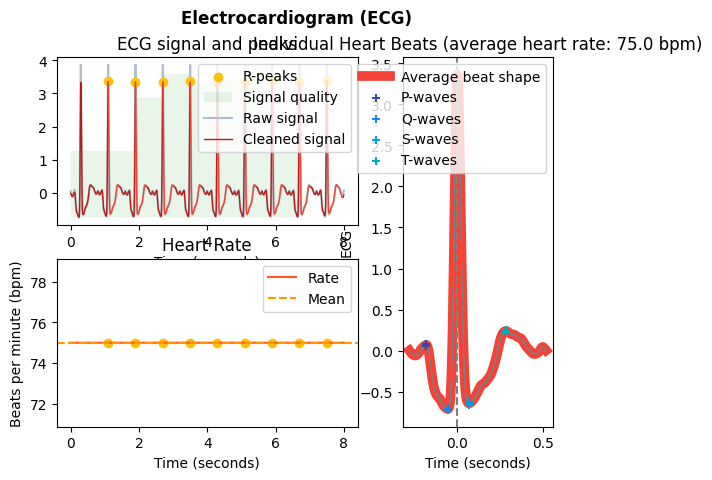

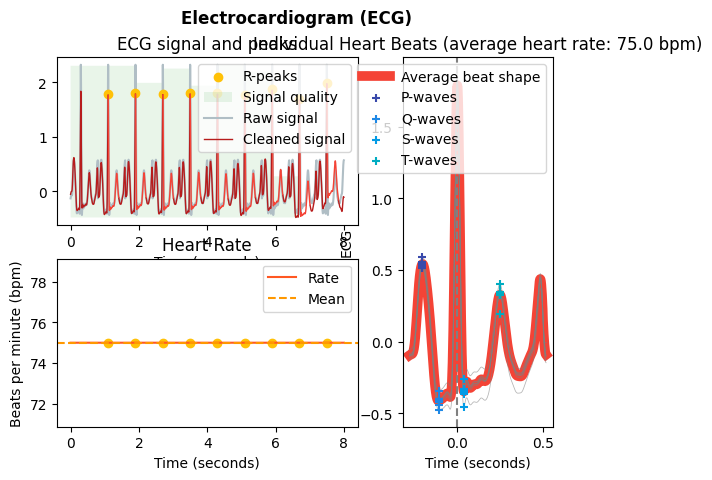

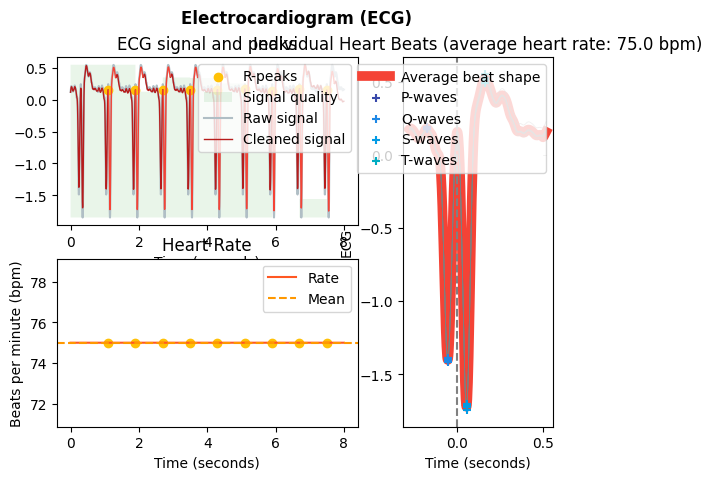

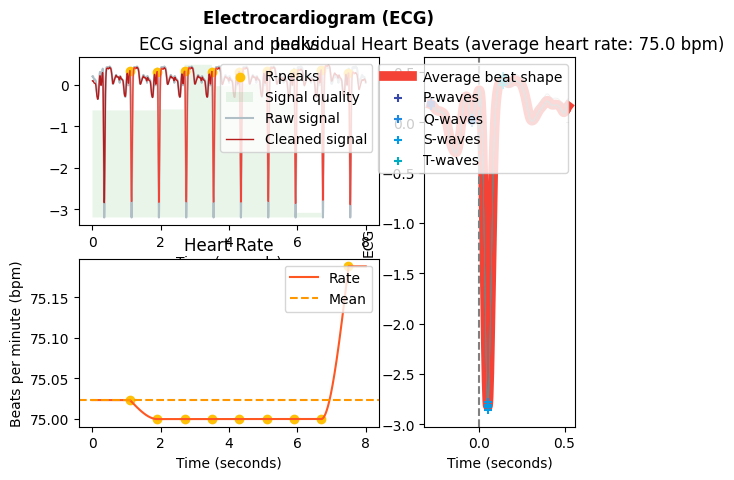

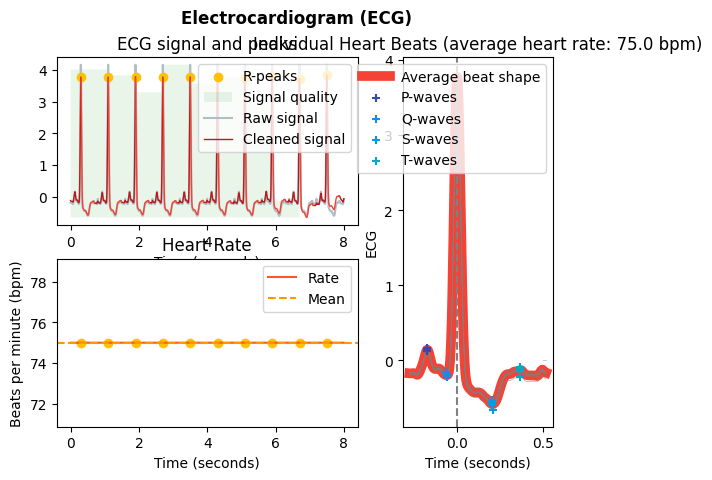

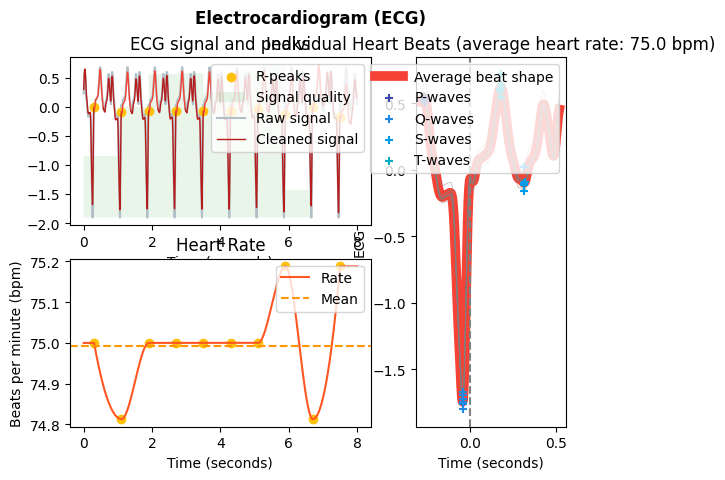

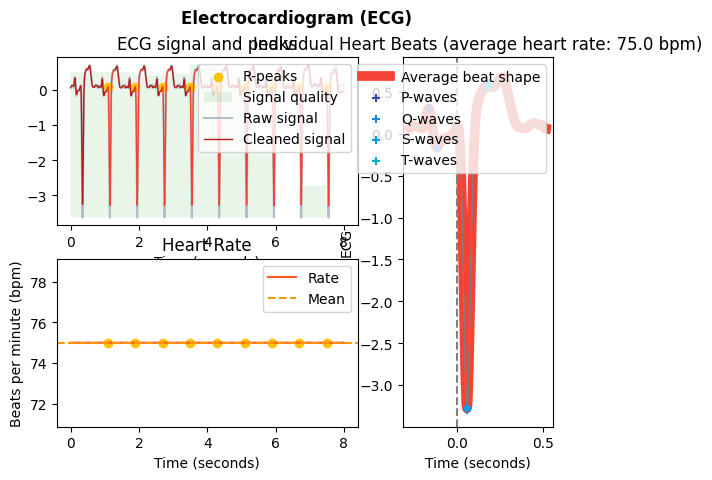

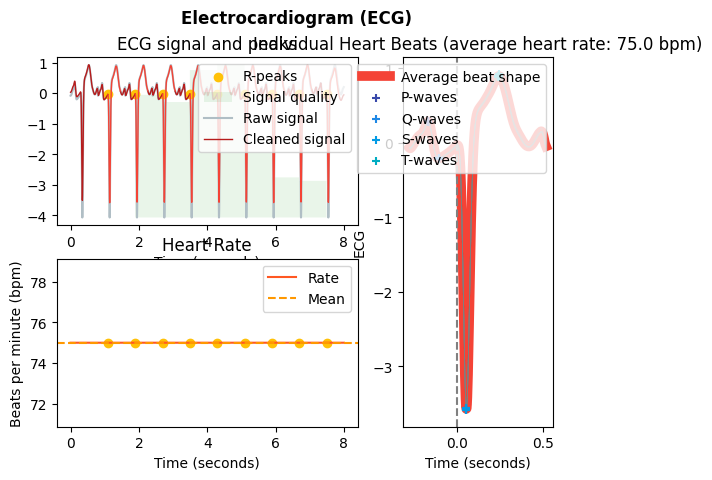

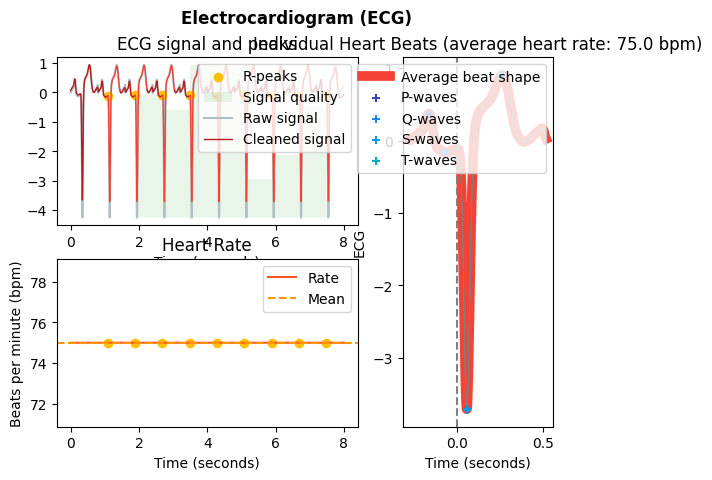

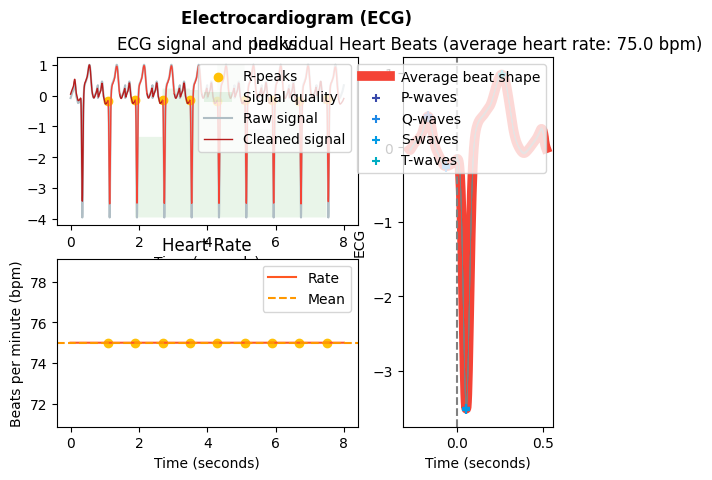

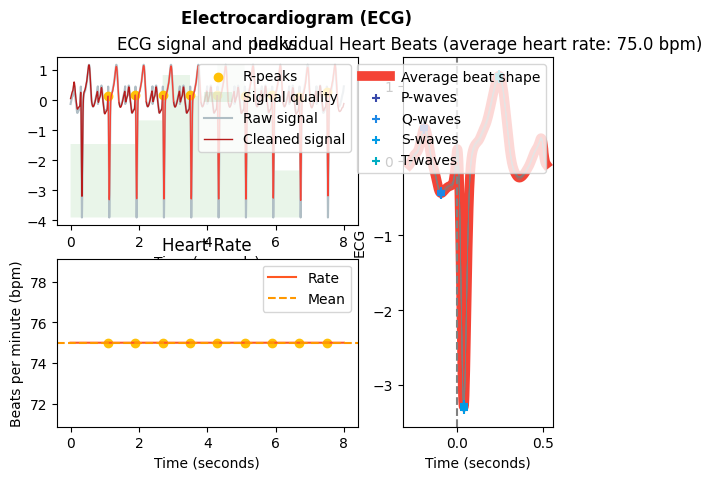

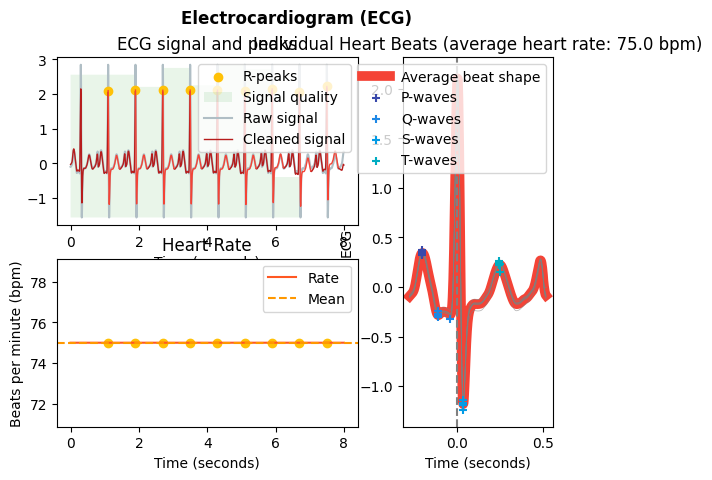

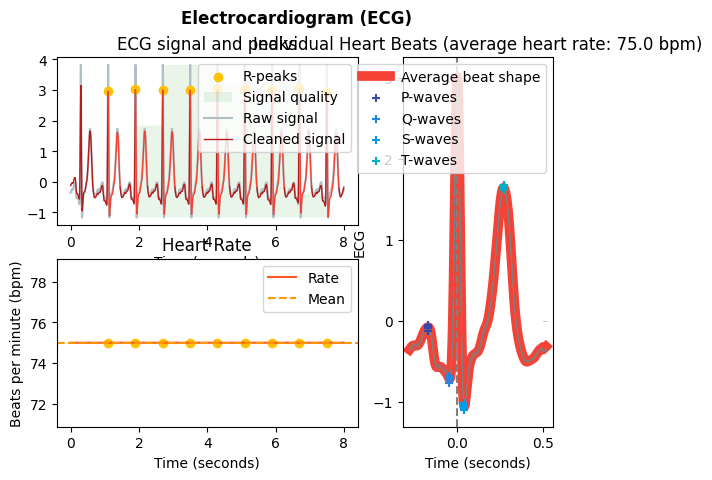

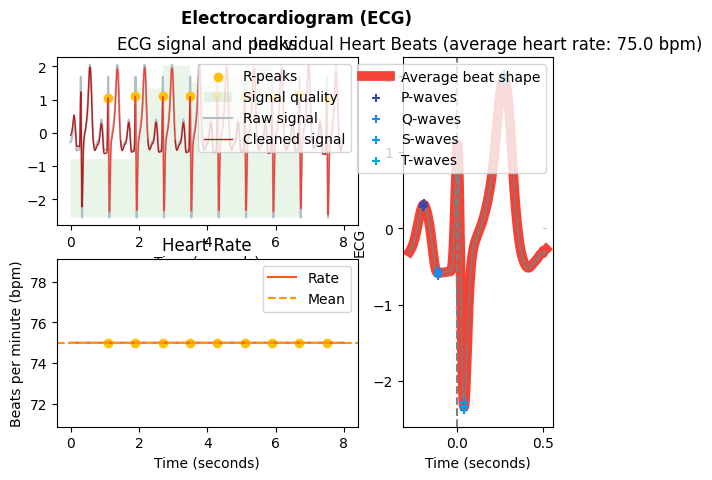

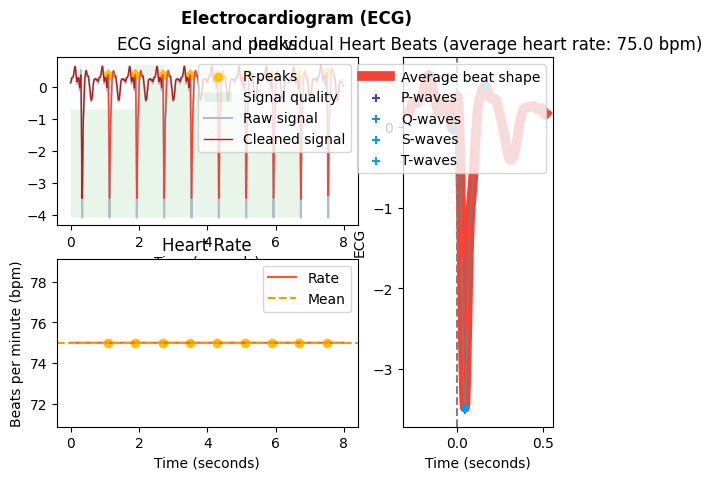

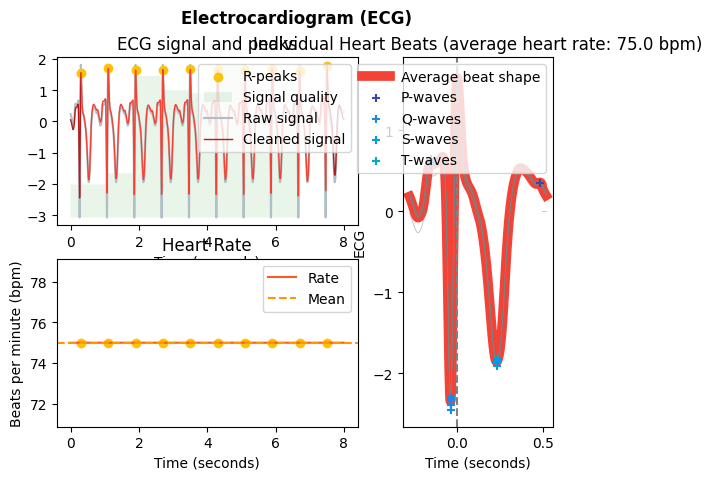

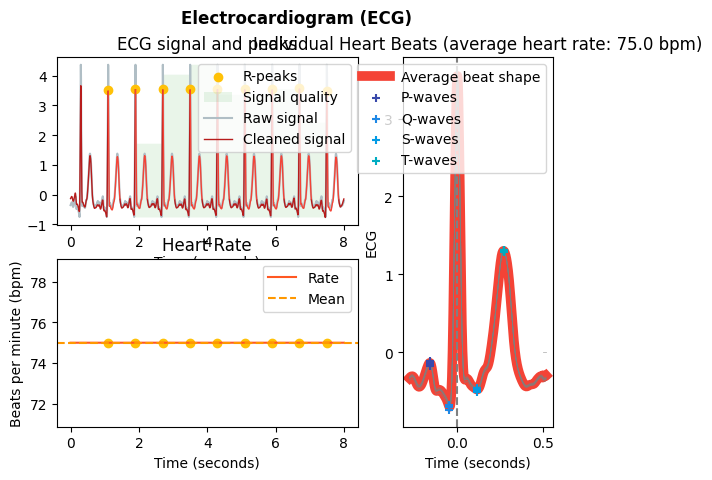

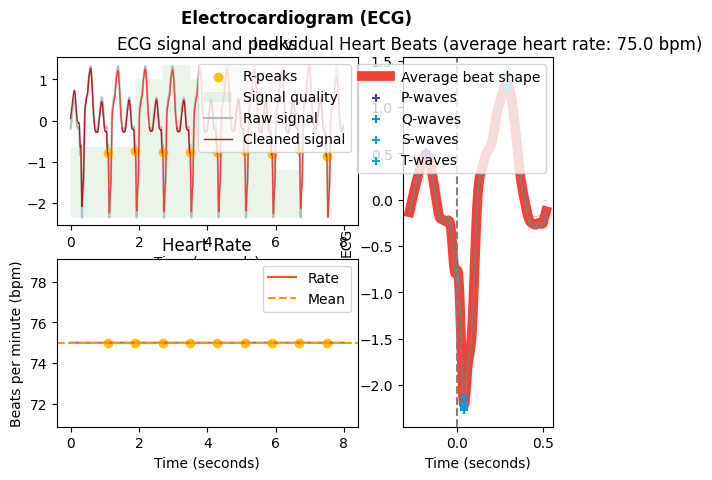

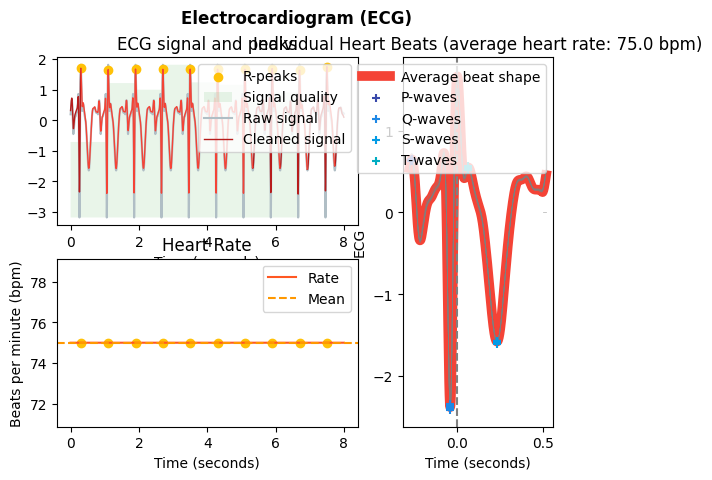

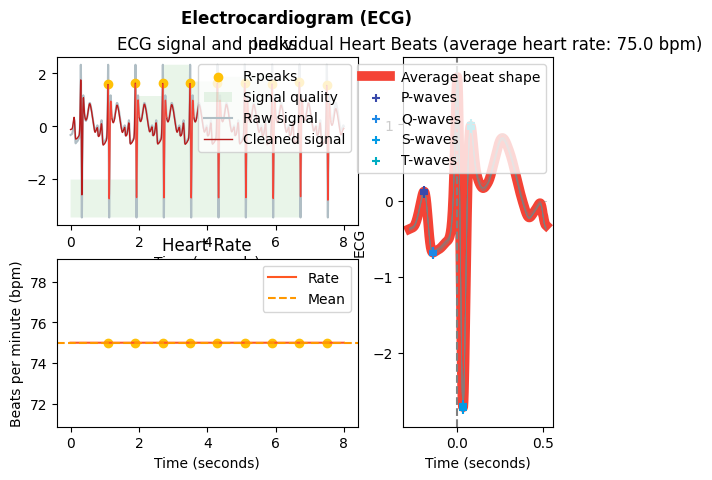

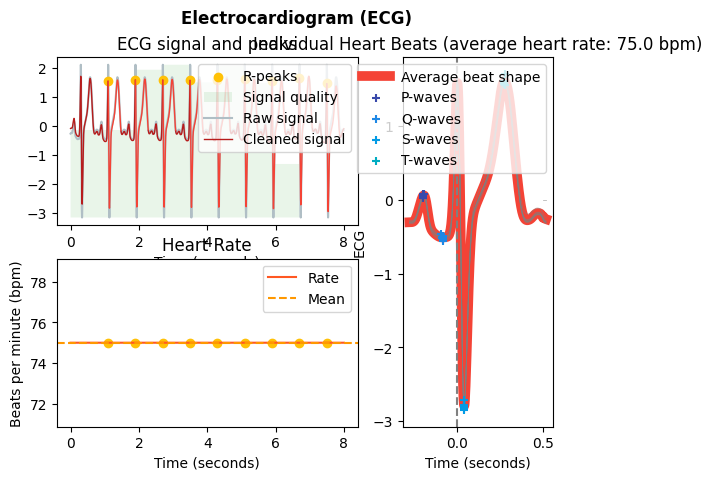

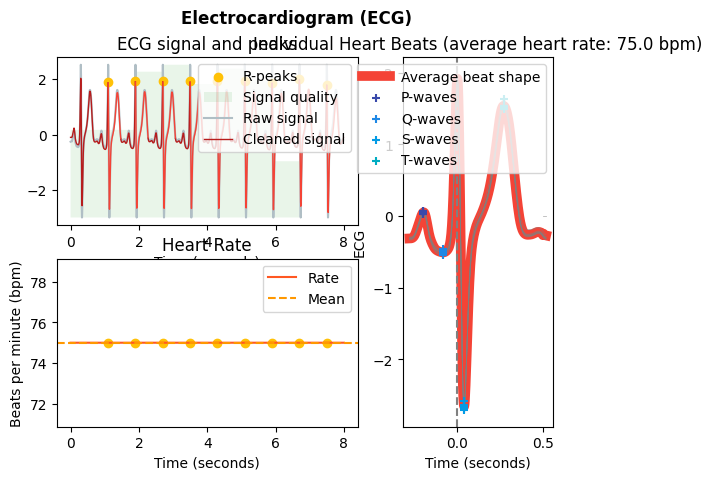

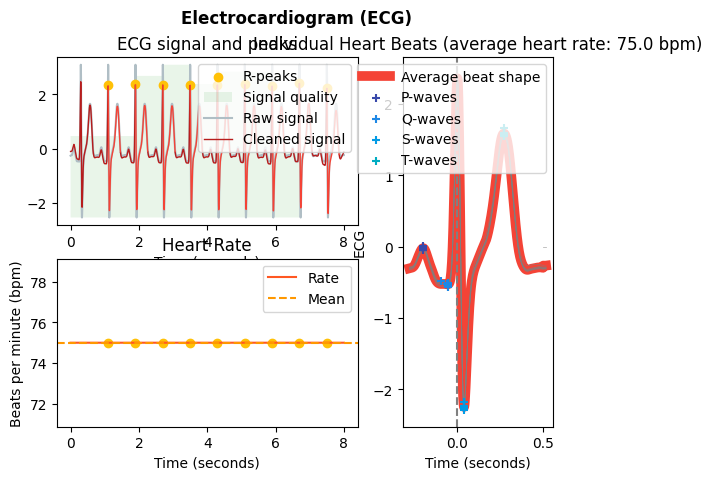

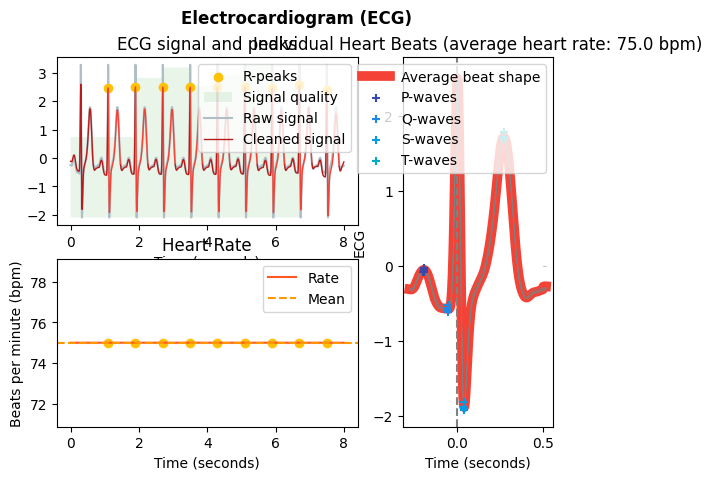

In [138]:
get_ecg_signals_features(
    processed_dir=path_to_zip/'ptb_xl_npz', 
    output_dir_features='ptb_xl_features_signal_morphology', method="dwt", 
    avg_signal=True, show_plot=True, calc_waves_peak=True,
    fs=fs, extractors=['morphology']
)

# Reading features

In [34]:
ptb_xl_features = pd.read_parquet(path_to_zip / 'ptb_xl_features_signal_morphology')

In [ ]:
#ptb_xl_features = pd.read_parquet(path_to_zip / 'ptb_xl_features')

In [35]:
low_ptb_xl_features = ptb_xl_features.dropna(axis=1, how='all')#.iloc[:200]

In [37]:
low_ptb_xl_features.dropna(axis=1, how='all')

,patient_id,target,file_name,age,sex,ECG_P_Onsets_amplitude_median_I,ECG_P_Onsets_amplitude_mean_I,ECG_P_Onsets_amplitude_std_I,ECG_P_Onsets_amplitude_q25_I,ECG_P_Onsets_amplitude_q75_I,...,T_area_corrected_q75_V6,T_area_corrected_min_V6,T_area_corrected_max_V6,T_QRS_ratio_median_V6,T_QRS_ratio_mean_V6,T_QRS_ratio_std_V6,T_QRS_ratio_q25_V6,T_QRS_ratio_q75_V6,T_QRS_ratio_min_V6,T_QRS_ratio_max_V6
0,20449,0.0,ecg_20449.npz,300,1,-0.376177,-0.388651,0.158087,-0.479782,-0.303636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2045,1.0,ecg_2045.npz,70,1,-0.274322,-0.317769,0.202480,-0.372930,-0.178484,...,0.139542,0.090375,0.150349,0.825354,0.995727,0.265568,0.798648,1.156839,0.754280,1.443513
2,20450,1.0,ecg_20450.npz,52,0,-0.252849,-0.361511,0.203665,-0.468281,-0.232139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20451,1.0,ecg_20451.npz,47,0,0.003318,0.005367,0.258168,-0.061164,0.089897,...,0.134529,0.106613,0.177308,1.200154,1.285011,0.209492,1.188469,1.422964,1.004295,1.609174
4,20451,1.0,ecg_20451.npz,47,0,0.003318,0.005367,0.258168,-0.061164,0.089897,...,0.134529,0.106613,0.177308,1.200154,1.285011,0.209492,1.188469,1.422964,1.004295,1.609174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18863,20443,1.0,ecg_20443.npz,50,1,-0.248135,-0.224311,0.157821,-0.376982,-0.085447,...,0.066007,0.043937,0.084954,0.485576,0.494633,0.086981,0.446233,0.542887,0.359024,0.633858
18864,20444,1.0,ecg_20444.npz,69,1,-0.117161,-0.121254,0.177196,-0.197125,0.041040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18865,20445,1.0,ecg_20445.npz,67,0,-0.047576,0.003549,0.203032,-0.109423,0.171465,...,0.009414,0.009414,0.009414,0.121215,0.121215,0.000000,0.121215,0.121215,0.121215,0.121215
18866,20446,1.0,ecg_20446.npz,50,1,-0.107781,-0.065668,0.214361,-0.156220,-0.017808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
low_ptb_xl_features.isna().sum()

patient_id               0
target                   0
file_name                0
age                      0
sex                      0
                      ... 
T_QRS_ratio_std_V6    4888
T_QRS_ratio_q25_V6    4888
T_QRS_ratio_q75_V6    4888
T_QRS_ratio_min_V6    4888
T_QRS_ratio_max_V6    4888
Length: 11765, dtype: int64

In [39]:
nan_counts = low_ptb_xl_features.isna().sum()
total_rows = len(low_ptb_xl_features)
nan_percentage = (nan_counts / total_rows) * 100

columns_to_keep = nan_percentage[nan_percentage <= 30].index
low_ptb_xl_features = low_ptb_xl_features[columns_to_keep]

In [40]:
cols_to_drop = [col for col in low_ptb_xl_features.columns if low_ptb_xl_features[col].nunique() == 1]
low_ptb_xl_features = low_ptb_xl_features.drop(columns=cols_to_drop)

In [41]:
columns_to_drop = [col for col in low_ptb_xl_features.columns 
                   if col.startswith(('TrappingTime', 'LEn_', 'L_', 'VEn_', 'RecurrenceRate'))]
low_ptb_xl_features = low_ptb_xl_features.drop(columns=columns_to_drop)

In [42]:
low_ptb_xl_features = low_ptb_xl_features[low_ptb_xl_features['age'] < 100]

In [43]:
low_ptb_xl_features

,patient_id,target,file_name,age,sex,ECG_P_Onsets_amplitude_median_I,ECG_P_Onsets_amplitude_mean_I,ECG_P_Onsets_amplitude_std_I,ECG_P_Onsets_amplitude_q25_I,ECG_P_Onsets_amplitude_q75_I,...,T_area_corrected_q75_V6,T_area_corrected_min_V6,T_area_corrected_max_V6,T_QRS_ratio_median_V6,T_QRS_ratio_mean_V6,T_QRS_ratio_std_V6,T_QRS_ratio_q25_V6,T_QRS_ratio_q75_V6,T_QRS_ratio_min_V6,T_QRS_ratio_max_V6
1,2045,1.0,ecg_2045.npz,70,1,-0.274322,-0.317769,0.202480,-0.372930,-0.178484,...,0.139542,0.090375,0.150349,0.825354,0.995727,0.265568,0.798648,1.156839,0.754280,1.443513
2,20450,1.0,ecg_20450.npz,52,0,-0.252849,-0.361511,0.203665,-0.468281,-0.232139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20451,1.0,ecg_20451.npz,47,0,0.003318,0.005367,0.258168,-0.061164,0.089897,...,0.134529,0.106613,0.177308,1.200154,1.285011,0.209492,1.188469,1.422964,1.004295,1.609174
4,20451,1.0,ecg_20451.npz,47,0,0.003318,0.005367,0.258168,-0.061164,0.089897,...,0.134529,0.106613,0.177308,1.200154,1.285011,0.209492,1.188469,1.422964,1.004295,1.609174
5,20451,1.0,ecg_20451.npz,47,0,0.003318,0.005367,0.258168,-0.061164,0.089897,...,0.134529,0.106613,0.177308,1.200154,1.285011,0.209492,1.188469,1.422964,1.004295,1.609174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18863,20443,1.0,ecg_20443.npz,50,1,-0.248135,-0.224311,0.157821,-0.376982,-0.085447,...,0.066007,0.043937,0.084954,0.485576,0.494633,0.086981,0.446233,0.542887,0.359024,0.633858
18864,20444,1.0,ecg_20444.npz,69,1,-0.117161,-0.121254,0.177196,-0.197125,0.041040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18865,20445,1.0,ecg_20445.npz,67,0,-0.047576,0.003549,0.203032,-0.109423,0.171465,...,0.009414,0.009414,0.009414,0.121215,0.121215,0.000000,0.121215,0.121215,0.121215,0.121215
18866,20446,1.0,ecg_20446.npz,50,1,-0.107781,-0.065668,0.214361,-0.156220,-0.017808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
